<a href="https://colab.research.google.com/github/LeeLucky789789/Sctrum/blob/main/%E6%8B%9F%E5%90%88%E9%87%8D%E8%A6%81%E5%AD%A6%E4%B9%A0%E5%85%A8%E5%B1%80%E6%96%B9%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

在本教程中，我们将查看瞬态数据全局拟合中最简单的示例之一。 我们将研究一种在被激发后只会通过荧光衰变的分子。

翻译：https://github.com/MaxParadiz/GlobalFitting

$$ E \xrightarrow[]{k_{fl}} GS + h \nu$$


当处于基态时，第一阶跃迁 (HOMO - LUMO) 被 650 nm 光子激发。 激发分子的最低能量跃迁在 400 nm。

让我们从绘制这两个分子的理想吸收光谱开始。

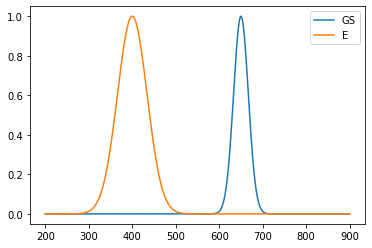

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Wavelength_Range = np.linspace(200,900,701)

# The simple way to define a gaussian is: a*e^{-((x-b)/c)**2}. In the form below, I am expressing it in terms
# of the full-width half maximum instead of 'c'.
# 定义高斯的简单方法是：a*e^{-((x-b)/c)**2}。 在下面的表格中，我用全角半高而不是“c”来表达它。"

Gaussian = lambda x,center,fwhm,amplitude : amplitude * np.exp(-4*np.log(2)*(x-center)**2/(fwhm**2))

# I will give both spectrums an equal amplitude of 1, but I will make the excited spectrum a bit
# broader by increasing its fwhm.
# 我会给两个频谱一个相等的振幅 1，但我会通过增加它的 fwhm 使激发频谱更宽一些。

Spectrum_GS = Gaussian(Wavelength_Range, 650,40,1)

Spectrum_E = Gaussian(Wavelength_Range, 400,80,1)

plt.plot(Wavelength_Range,Spectrum_GS,label='GS')
plt.plot(Wavelength_Range,Spectrum_E,label='E')
plt.legend()

在瞬态实验中，我们在每个延迟时间收集“差异频谱”。 该差异光谱是通过从“泵浦”吸收光谱中减去“未泵浦”吸收光谱而产生的。

实际上，泵浦吸收和非泵浦吸收之间的差异很小，因为只有一小部分分子被激发。

如果泵激发 10% 的分子，则原始泵浦和未泵浦吸收光谱将如下所示：

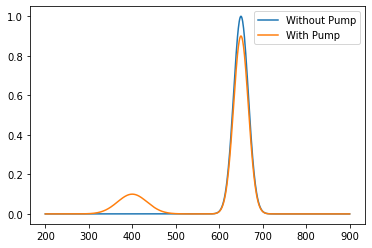

In [3]:
Spectrum_NoPump = Spectrum_GS
Spectrum_Pump = 0.9*Spectrum_GS + 0.1*Spectrum_E

plt.plot(Wavelength_Range,Spectrum_NoPump,label='Without Pump')
plt.plot(Wavelength_Range,Spectrum_Pump,label='With Pump')
plt.legend()

差异谱被计算为光谱之间的差。

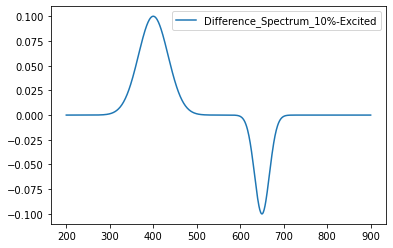

In [4]:
Difference_Spectrum = Spectrum_Pump-Spectrum_NoPump
plt.plot(Wavelength_Range,Difference_Spectrum,label='Difference_Spectrum_10%-Excited')
plt.legend()



如果你回顾一下差分谱是如何计算的，你可以检查它是否可以简化为： 

$$\omega_{Diff} = C_{E} * (\omega_{E} - \omega_{GS} )$$
 
 


 光谱 $SAS_E =(\omega_{E} - \omega_{GS} )$ 因此被称为激发态“E”的“物种相关光谱”（SAS）。

同理，GS 的 SAS 是 $SAS_{GS} = (\omega_{GS} - \omega_{GS}) = 0$

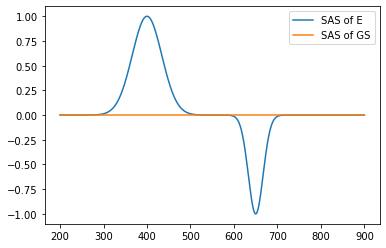

In [5]:

# Plot of the species assoiated spectra

SAS_E = Spectrum_E - Spectrum_GS
SAS_GS = Spectrum_GS - Spectrum_GS

plt.plot(Wavelength_Range,SAS_E,label='SAS of E')
plt.plot(Wavelength_Range,SAS_GS,label='SAS of GS')
plt.legend()

当我们收集光谱时，总光谱包含在特定时间溶液中存在的每个物种的物种相关光谱。 特定 SAS 的贡献量或权重取决于其相关物种在给定时间的浓度。

在本教程中，我们将模拟以下内容： 在 $ t = t_0$ 处，立即创建 E 的激发态群*。 忽略任何溶剂松弛、几何重排或振动冷却。 E 衰变的唯一途径是通过荧光。

$$\frac{dC_{E}}{dt} = -k_{fl}C_{E}$$ 
$$C_{E}(t) = C_{E}(0) \ e^{-k_{fl}t} = C_{E}(0) \ e^{-t/\tau_{fl}}$$

其中 $\tau_{fl} = 1/k_{fl}$ 是荧光寿命。

由于 E 的 SAS 是唯一存在的非零频谱，我们在任何给定时间的瞬态频谱可以表示为：

$$Transient \ Spectrum = C_{E}(t) \times \ SAS_E$$

*这绝不是真的，因为脉冲的宽度是有限的。 有时它是好的。 进行这种近似，但通常不是......布局的增加是“仪器响应函数”（IRF）建模的一部分，但我们不会在本教程中讨论这一点。

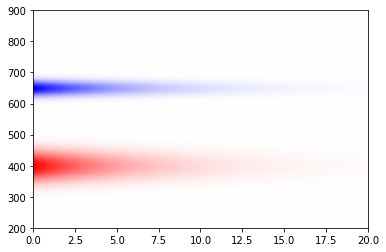

In [6]:
# Lets define the function CE(t)

CEt = lambda tau,CE0,t : CE0*np.exp(-t/tau)

# Lets define t to go from 0 to 20 ns...

t = np.linspace(0,20,100)

# Now lets let CE0 = 1, assign a fluorescence lifetime of 5 ns to our excited state, and create the CEt vector...

CEt_vector = CEt(5,1,t)

TS = np.outer(SAS_E,CEt_vector)

plt.pcolormesh(t,Wavelength_Range,TS,cmap='bwr')

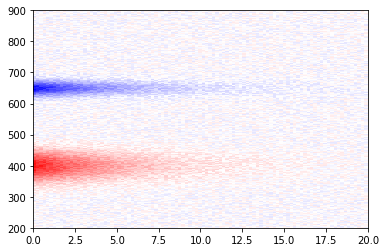

In [7]:
# Ral data is never so perfect.. So let's add some noise!
noise = (np.random.rand(*TS.shape)-0.5)/5
TS += noise
plt.pcolormesh(t,Wavelength_Range,TS,cmap='bwr')

在处理您的数据时，这个瞬态数据矩阵是您的起点（在您加载数据之后）。 当然，在实际分析中，我们既不知道光谱、动力学常数，也不知道先验的动力学模型！ 目标是通过将合理的模型拟合到数据来获得与物种相关的光谱和动力学。 我们现在将向后工作并从这些数据中获取模型。

Text(0.5, 1.0, '400.0 nm')

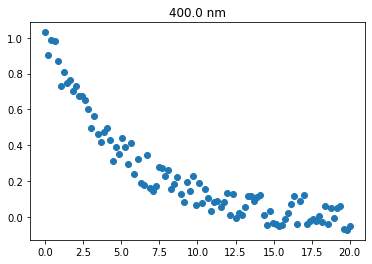

In [8]:
# Let's now plot the noisy decay trace of the excited state absorption band at 400 nm
plt.scatter(t,TS[200,:])
plt.title("%s nm" % Wavelength_Range[200])

我们现在将 400 nm 处的信号衰减拟合为单指数：

The fluorescence lifetime is 4.68 +/- 0.15 ns


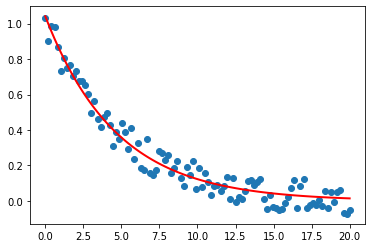

In [9]:
from scipy.optimize import curve_fit

def mono_exponential_model(t,a,tau):
    return a*np.exp(-t/tau)

# Alternative form: 
# mono_exponential_model = lambda t,A,tau: A*np.exp(-t/tau)

popt,pcov = curve_fit(mono_exponential_model,t,TS[200,:])
plt.scatter(t,TS[200,:])
plt.plot(t,mono_exponential_model(t,*popt),c='r',lw=2)
print("The fluorescence lifetime is %0.2f +/- %0.2f ns" % (popt[1],np.sqrt(pcov[1,1])))

我们可以看到，我们的实际值 5 ns 落入了拟合值的范围内，并带有误差！ 那挺好的。
如果我们现在独立地拟合多条线会发生什么？

The fluorescence lifetime at 350 nm is 5.47 +/- 0.52 ns
The fluorescence lifetime at 375 nm is 4.59 +/- 0.20 ns
The fluorescence lifetime at 400 nm is 4.68 +/- 0.15 ns
The fluorescence lifetime at 425 nm is 4.93 +/- 0.19 ns
The fluorescence lifetime at 450 nm is 4.71 +/- 0.40 ns


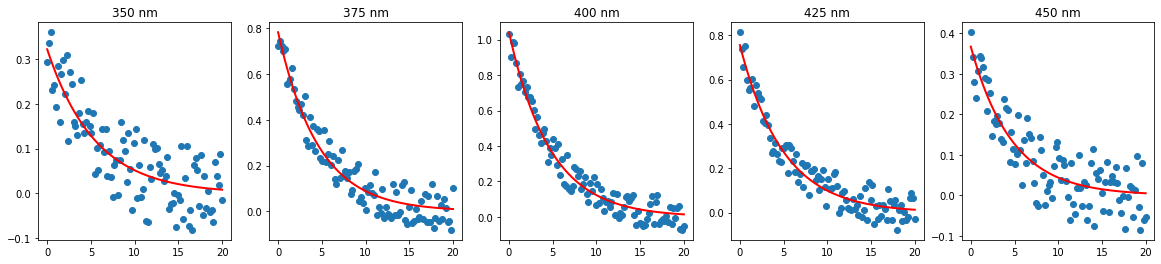

In [10]:
Selection = [150,175,200,225,250] # The slection of indexes for performing the fit.
fig = plt.figure()
fig.set_figwidth(20)
for i in range(0,5):
    wL = int(Wavelength_Range[Selection[i]])
    plt.subplot(1,5,i+1)
    popt,pcov = curve_fit(mono_exponential_model,t,TS[Selection[i],:])
    plt.scatter(t,TS[Selection[i],:])
    plt.plot(t,mono_exponential_model(t,*popt),c='r',lw=2)
    plt.title("%s nm" % wL)
    print("The fluorescence lifetime at %s nm is %0.2f +/- %0.2f ns" % (wL, popt[1],np.sqrt(pcov[1,1])))

我们可以看到每条线的预测时间常数略有不同。 我们知道这不应该是这样的！ 整个信号取决于单个物种的衰减，因此它们都应该以相同的方式衰减。 同时拟合所有这些曲线的过程称为“全局拟合”。

首先让我们使用不太优雅的蛮力方法执行全局拟合。 我们想要做的是拟合所有这些曲线，每条曲线使用不同的“A”但共享 tau。 我还不确定如何用语言来解释它，所以我就去做吧。

第一步就是把这五个d拼接起来

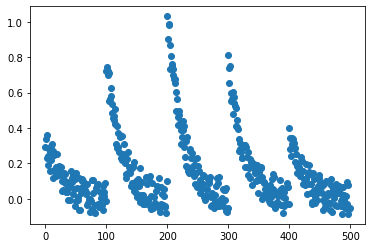

In [11]:
Stitched_Data = []
for i in Selection:
    Stitched_Data.append(TS[i,:])


Stitched_Data = np.asarray(Stitched_Data).flatten()
x = range(len(Stitched_Data)) # We don't want to use t as the x axis at this point! 
plt.scatter(x,Stitched_Data)

也许你现在明白这是怎么回事了......我们现在拥有了我们想要放在同一个数组中的所有点，所以我们现在需要做的就是生成一个具有相同格式的猜测数组！ 同样，我将向您展示它是如何完成的，希望它是有道理的。 否则让我知道，我会看看我如何更好地解释它。

In [14]:
def global_model(t,a1,a2,a3,a4,a5,tau):
    A = [a1,a2,a3,a4,a5]
    guess = []
    for a in A:
        guess.append(a*np.exp(-t/tau))
    return np.asarray(guess).flatten()

这个新模型将使用相同的 tau 遍历每个 a，然后输出一个与拼接数据格式相同的猜测数组！ 现在让我们进行拟合！

The globally fitted fluorescence lifetime is 4.75 +/- 0.10 ns


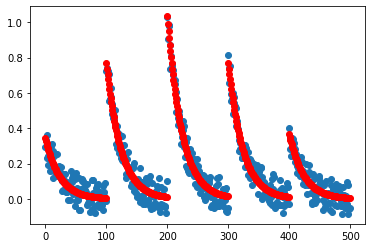

In [15]:
popt,pcov = curve_fit(global_model,t,Stitched_Data) # Perform the global fit
plt.scatter(x,Stitched_Data)
plt.scatter(x,global_model(t,*popt),color='r')
print("The globally fitted fluorescence lifetime is %0.2f +/- %0.2f ns" % (popt[5],np.sqrt(pcov[5,5])))

现在您肯定想知道：但是 Max！ 为什么我们不直接在 global_model 中将 'A' 作为向量传递，而不是传递 a1,a2,a3,a4,a5？！ 
如果我们想同时拟合 701 个波长，我们将需要创建一个很长的列表......
原因很简单：curve_fit 确实允许您拟合向量。

 你可以尝试一下，但它会失败。 现在让我们使用 least_squares 代替。 最小二乘法的工作方式几乎相同，只是“模型函数”应返回残差。

The globally fitted fluorescence lifetime is 4.75 +/- 0.10 ns


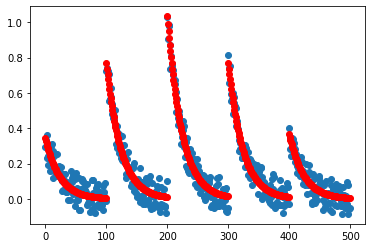

In [16]:
from scipy.optimize import least_squares

def global_model(G,t,measured_data): #NOTE: Now the parameters to be fitted (G) are the first parameters for the function, unlike for curve_fit!
    A = G[0:-1]
    tau = G[-1]
    guess = []
    for a in A:
        guess.append(a*np.exp(-t/tau))
    return (np.asarray(guess).flatten() - measured_data) # Must return the resudials (guess - measurement)

G0 = np.ones(6) # For this method you MUST provide an initial guess array!
res_lsq = least_squares(global_model,G0,args=(t,Stitched_Data))

plt.scatter(x,Stitched_Data)
plt.scatter(x,global_model(res_lsq.x,t,Stitched_Data)+Stitched_Data,color='r')


# The errors are  a bit trickier to calculate, because this method won't do it automatically for us...
# But don't worry too much about this part for now.

_, s, VT = np.linalg.svd(res_lsq.jac,full_matrices=False)
threshold = np.finfo(float).eps * max(res_lsq.jac.shape)*s[0]
s = s[s>threshold]
VT = VT[:s.size]
pcov = np.dot(VT.T / s**2, VT)
s_sq = (global_model(res_lsq.x,t,Stitched_Data)**2).sum()/(len(Stitched_Data.flatten())-len(G0))
pcov = pcov * s_sq
err = np.sqrt(np.diag(pcov))
print("The globally fitted fluorescence lifetime is %0.2f +/- %0.2f ns" % (res_lsq.x[5],err[5]))

如您所见，使用least_squares 方法我们得到了完全相同的结果。 正如我们应该做的，因为我们基本上和 curve_fit 做的事情是一样的。

这样做似乎是额外的工作，但它给了我们一个新的超能力：我们现在能够拟合向量！ 对于这种“愚蠢的拟合”，它为我们节省了必须明确键入 700 a 的工作，但是当我们使用线性代数进入更高级的拟合方法时，此属性将变得必不可少。

现在，我将这种愚蠢的拟合方法发挥到极致，并执行整个全局拟合

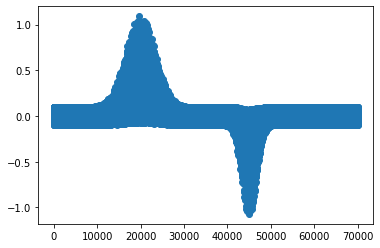

In [17]:

y = TS.flatten()
x = range(len(y))
plt.scatter(x,y)

一开始可能不太容易看到，但上面的情节确实是所有缝合的衰变。 您可以“放大”区域以查看详细信息：

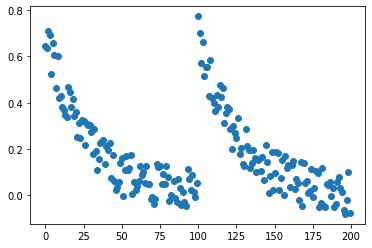

In [18]:
plt.scatter(range(len(y[22800:23000])),y[22800:23000])

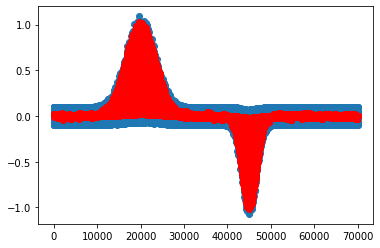

In [19]:

G0 = np.ones(len(Wavelength_Range)+1)
res_lsq = least_squares(global_model,G0,args=(t,y))
plt.scatter(x,y)
plt.scatter(x,global_model(res_lsq.x,t,y)+y,color='r')

# This might take a while...

我们现在可以提取拟合光谱和衰减！

The globally fitted decay lifetime is 4.97 +/- 0.02 ns


Text(0.5, 1.0, 'Fitted Spectrum')

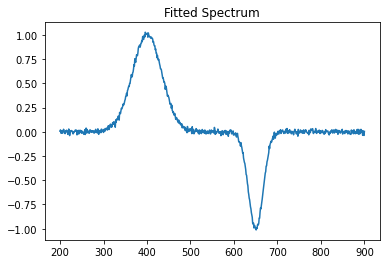

In [20]:

Spectrum = res_lsq.x[0:-1]
tau = res_lsq.x[-1]


##### Error calculation
_, s, VT = np.linalg.svd(res_lsq.jac,full_matrices=False)
threshold = np.finfo(float).eps * max(res_lsq.jac.shape)*s[0]
s = s[s>threshold]
VT = VT[:s.size]
pcov = np.dot(VT.T / s**2, VT)
s_sq = (global_model(res_lsq.x,t,y)**2).sum()/(len(y.flatten())-len(G0))
pcov = pcov * s_sq
err = np.sqrt(np.diag(pcov))
##### END error calculation

print("The globally fitted decay lifetime is %0.2f +/- %0.2f ns" % (res_lsq.x[-1],err[-1]))
Spectrum_Error = err[0:-1]
plt.plot(Wavelength_Range,Spectrum)
#plt.fill_between(Wavelength_Range,Spectrum+Spectrum_Error,Spectrum-Spectrum_Error,color='r') # Spectrum error in red
plt.title('Fitted Spectrum')


如您所见，通过全局拟合，我们现在以非常小的误差获得了对频谱的极好拟合！


在教程 2 中，我将更深入地讨论矩阵，但在下面您可以看到如何使用矩阵运算而不是 for 循环来执行此拟合。 

本质上，如果您回顾输入 6，我们通过执行光谱和浓度随时间的外积来生成瞬态矩阵。 

在大多数情况下，我们将使用更多维度，因此我们将使用“np.dot()”代替。 我们现在需要以这种形式创建我们的模型。

 在大多数情况下，我们将使用点积而不是外积函数。

In [21]:
def matrix_model(G,t,measured_data):
    Spectrum = G[0:-1]
    tau = G[-1]
    CE = np.exp(-t/tau)
    guess = np.outer(Spectrum,CE)
    return (guess-measured_data).flatten() # We can work with matrices within the model, but the residuals must always be returned as an array

G0 = np.ones(len(Wavelength_Range)+1)
res_lsq = least_squares(global_model,G0,args=(t,y))